In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("AQI.ipynb")

# Final Project: Air Quality Dataset
## Analyzing and Predicting AQI Data through Modeling
## Due Date: Thursday, December 17th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

## This Assignment

In this final project, we will investigate AQI data for the year 2020 from **USA EPA** data. All the data used for this project can be accessed from the [EPA Website](https://aqs.epa.gov/aqsweb/airdata/download_files.html), which we will pull from directly in this notebook. This dataset contains geographical and time-series data on various factors that contribute to AQI from all government sites. The main goal at the end for you will be to understand how AQI varies both geographically and over time, and use your analysis (as well as other data that you can find) to be predict AQI at a certain point in time for various locations in California.

Through this final project, you will demonstrate your experience with:
* EDA and merging on location using Pandas
* Unsupervised and supervised learning techniques
* Visualization and interpolation

This is **part 1** of the project, which includes the data cleaning, guided EDA and open-ended EDA components of the project. This will help you for part 2, where you will be completing the modeling component. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

<br/><br/>

---
## Section 1: Data Cleaning

As mentioned, we will be using the **US EPA** data from the EPA website. Below is a dataframe of the files we will be using for the project. The following two cells will download the data and put it into a dictionary called `epa_data`.

In [3]:
epa_weburl = "https://web.archive.org/web/20211118232504/https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("data/epa_filenames.csv")
epa_filenames


,name,epa_filename
0,annual_county_aqi,annual_aqi_by_county_2020
1,daily_county_aqi,daily_aqi_by_county_2020
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


Below is code that we used to extract the code from the AQI website, which we encourage you to understand! This will pull directly from the website urls and put it into your `data/` folder. 

In [4]:

# epa_data = {}
# for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
#     path_name = 'data/{}'.format(name)
#     # if not os.path.isdir(path_name): 
#     data_url = '{}{}.zip'.format(epa_weburl, filename)
#     req = requests.get(data_url)
#     z = zipfile.ZipFile(io.BytesIO(req.content))
#     z.extractall(path_name)
#     data = pd.read_csv(f'data/{name}/{filename}.csv')
#     epa_data[name] = data
    
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name):
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

Use the below cell to explore each of the datasets, which can be accessed using the keys in the `name` column of `epa_filenames` above. Currently, the cell is viewing the `annual_county_aqi` dataset, but feel free to change it to whichever dataset you want to explore. 

In [5]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- BEGIN QUESTION -->

<br/>

### Question 0: Understanding the Data

Notice that for the table `annual_county_aqi`, the 90th percentile AQI is reported as a column. Why would the 90th percentile AQI be useful as opposed to the maximum? What does it mean when the difference between the 90th percentile AQI and Max AQI is very large compared to the difference between the 90th percentile AQI and the median AQI?

<!--
BEGIN QUESTION
name: q0
manual: True
points: 2
-->

We use 90th percentile AQI to prevent extreme outliers from biasing the data. If the difference between the 90th percentile AQI and MAX AQI is very large, then there exists some extreme outliers. 

<!-- END QUESTION -->

<br/>

### Question 1a: Creating Month and Day Columns

In the `daily_county_aqi` table in `epa_data`, add two new columns called `Day` and `Month` that denote the day and month, respectively, of the AQI reading. The day and month should both be reported as an **integer** as opposed to a string (`Jan`, `Feb`, etc.)

hint: `pd.to_datetime` may be useful.

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [6]:
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.DatetimeIndex(daily_county['Date']).month
daily_county['Day'] = pd.DatetimeIndex(daily_county['Date']).day

daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [7]:
grader.check("q1a")

q1a results: All test cases passed!

<br/>

### Question 1b: California Data

Currently, `epa_data` contains data for **all** counties in the United States. For the guided part of this project, we are specifically going to be focusing on AQI data for counties in California only. Your task is to assign `epa_data_CA` a dictionary mapping table names to dataframes. This map should have the same contents as `epa_data` but only tables that contain **daily data** in the state of `California`.

<!--
BEGIN QUESTION
name: q1b
points: 3
-->

In [8]:
epa_data_CA = {}

names = ['daily_county_aqi', 'daily_ozone', 'daily_so2', 'daily_co', 'daily_no2', 'daily_temp', 'daily_wind']
for name in names:
    df = epa_data.get(name)
    df = df[df['State Name'] == 'California']
    epa_data_CA[name] = df
    
epa_data_CA.get('daily_county_aqi').head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
14003,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
14004,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
14005,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
14006,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
14007,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


In [9]:
grader.check("q1b")

q1b results: All test cases passed!

<br/>

### Question 1c: Merging Site Information

Now take a look at this [link](https://www.epa.gov/outdoor-air-quality-data/about-air-data-reports) and look under "Site ID". For later analysis, we want to first get the latitude and longitudes of each of the measurements in the `daily_county_aqi` table by merging two or more tables in `epa_data_CA` (one of the tables is `daily_county_aqi`).

Our final merged table should be assigned to `epa_data_CA_merged` and the result should contain the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Latitude`, and `Longitude`

<!--
BEGIN QUESTION
name: q1c
points: 4
-->

In [15]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
aqs_sites = epa_data.get('aqs_sites')
daily_county_aqi = epa_data_CA.get('daily_county_aqi')

aqs_sites['State ID'] = aqs_sites['State Code'].astype(str).str.zfill(2)
aqs_sites['County ID'] = aqs_sites['County Code'].astype(str).str.zfill(3)
aqs_sites['Site ID'] = aqs_sites['Site Number'].astype(str).str.zfill(4)
aqs_sites['Defining Site'] = aqs_sites['State ID'] + '-' + aqs_sites['County ID'] + '-' + aqs_sites['Site ID']
aqs_sites = aqs_sites[['Latitude', 'Longitude', 'Defining Site']] 
new_df = daily_county_aqi.merge(aqs_sites,  how='left', left_on=['Defining Site'], right_on = ['Defining Site'])
epa_data_CA_merged = new_df[cols]

epa_data_CA_merged.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217


In [16]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

### Question 2a - Cleaning Traffic Data 

Throughout this project, you will be using other datasets to assist with analysis and predictions. Traditionally, to join dataframes we need to join on a specific column with shared values. However, when it comes to locations, exact latitudes and longitudes are hard to come by since it is a continuous space. First, lets look at such a dataset that we may want to merge on with `epa_data_CA_merged`. 

In the below cell, we have loaded in the `traffic_data` dataset, which contains traffic data for various locations in California. Your task is to clean this table so that it includes only the following columns (you may have to rename some): `District`, `Route`, `County`, `Descriptn`, `AADT`, `Latitude`, `Longitude`, where `AADT` is found by taking the sum of the back and ahead `AADT`s (you may run into some issues with cleaning the data in order to add these columns - `.str` functions may help with this). The metric AADT, annual average daily traffic, is calculated as the sum of the traffic north of the route (ahead AADT) and south of the route (back AADT). You also need to make sure to clean and remove any illegal values from the dataframe (hint: check `Latitude` and `Longitude`).

*Hint:* `str` functions you will likely use: `.strip()`, `.replace()`.

<!--
BEGIN QUESTION
name: q2a
points: 3
-->

In [17]:
traffic_data = pd.read_csv("data/Traffic_Volumes_AADT.csv")
cols = ['District', 'Route', 'County', 'Descriptn', 'AADT', 'Latitude', 'Longitude']

traffic_data_cleaned = pd.DataFrame()
traffic_data_cleaned['District'] = traffic_data['District']
traffic_data_cleaned['Route'] = traffic_data['Route']
traffic_data_cleaned['County'] = traffic_data['County']
traffic_data_cleaned['Descriptn'] = traffic_data['Descriptn']
traffic_data_cleaned['AADT'] = traffic_data['Back_AADT'].str.replace(r'\s', '0').astype(int) + traffic_data['Ahead_AADT'].str.replace(r'\s', '0').astype(int)
traffic_data_cleaned['Latitude'] = traffic_data['Lat_S_or_W']
traffic_data_cleaned['Longitude'] = traffic_data['Lon_S_or_W']

traffic_data_cleaned = traffic_data_cleaned[traffic_data_cleaned['Longitude'] != 'Left Skipped - Input PM on Right Ind. Alignment']
traffic_data_cleaned = traffic_data_cleaned[traffic_data_cleaned['Latitude'] != 'Left Skipped - Input PM on Right Ind. Alignment']

traffic_data_cleaned.head()

,District,Route,County,Descriptn,AADT,Latitude,Longitude
0,1,1,MEN,SONOMA/MENDOCINO COUNTY LINE,4000,38.75984264,-123.5185026
1,1,1,MEN,NORTH LIMITS GUALALA,7100,38.77004592,-123.53189
2,1,1,MEN,FISH ROCK ROAD,6200,38.80354931,-123.585411
3,1,1,MEN,"POINT ARENA, SOUTH CITY LIMITS",4600,38.90397338,-123.6915134
4,1,1,MEN,"POINT ARENA, RIVERSIDE DRIVE",5000,38.91091252,-123.6924099


In [18]:
grader.check("q2a")

q2a results: All test cases passed!

### Question 2b - Merging on Traffic Data 

Traditionally, we could employ some sort of join where we join `epa_data_CA_merged` rows with the row in `traffic_data` that it is the "closest" to, as measured by euclidean distance. As you can imagine, this can be quite tedious so instead we will use a special type of join called a **spatial join**, which can be done using the package `geopandas`, which is imported as `gpd`. The documentation for `geopandas` is linked [here](https://geopandas.org/docs/reference/api/geopandas.sjoin_nearest.html). Please use this as a resource to do the following tasks: 

 - turn `traffic_data_cleaned` and `epa_data_CA_merged` into a geopandas dataframe using the latitude and longitude.
 - Use a spatial join (which function is this in the documentation?) to match the correct traffic row information to each entry in `epa_data_CA_merged`. 

Your final dataframe should be assigned to `gpd_epa_traffic` with the following columns: `State Name`, `county Name`, `Month`, `Day`, `AQI`, `Category`, `Defining Site`, `Site Lat`, `Site Long`, `Traffic Lat`, `Traffic Long`, `Descriptn`, and `AADT`.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [19]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Site Lat', 'Site Long', 'Traffic Lat', 'Traffic Long', 'Descriptn', 'AADT']

temp = epa_data_CA_merged.copy()
gdf_epa = gpd.GeoDataFrame(
    temp, geometry=gpd.points_from_xy(temp.Longitude, temp.Latitude))
gdf_epa = gdf_epa.rename(columns = {'Latitude': 'Site Lat', 'Longitude':'Site Long'})

gdf_traffic = gpd.GeoDataFrame(
    traffic_data_cleaned, geometry=gpd.points_from_xy(traffic_data_cleaned.Longitude.astype(float), traffic_data_cleaned.Latitude.astype(float)))
gdf_traffic = gdf_traffic.rename(columns = {'Latitude': 'Traffic Lat', 'Longitude' : 'Traffic Long'})

gpd_epa_traffic = gpd.sjoin_nearest(gdf_epa, gdf_traffic)
gpd_epa_traffic = gpd_epa_traffic[cols]
gpd_epa_traffic['Traffic Long'] = gpd_epa_traffic['Traffic Long'].astype(float)
gpd_epa_traffic['Traffic Lat'] = gpd_epa_traffic['Traffic Lat'].astype(float)
gpd_epa_traffic['Site Long'] = gpd_epa_traffic['Site Long'].astype(float)
gpd_epa_traffic['Site Lat'] = gpd_epa_traffic['Site Lat'].astype(float)
gpd_epa_traffic.head()

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Site Lat,Site Long,Traffic Lat,Traffic Long,Descriptn,AADT
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
24,California,Alameda,1,25,40,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
184,California,Alameda,7,3,48,Good,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
185,California,Alameda,7,4,115,Unhealthy for Sensitive Groups,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300
186,California,Alameda,7,5,78,Moderate,06-001-0009,37.743065,-122.169935,37.744352,-122.170586,"OAKLAND, 98TH AVENUE",48300


In [20]:
grader.check("q2b")

q2b results: All test cases passed!

<br/><br/>

---
## Section 2: Guided EDA


### Question 3a: Initial AQI Analysis

Assign a `pd.Series` object to `worst_median_aqis` that contains the states with the top 10 worst median AQIs throughout the year 2020, as measured by the average median AQIs across all counties for a single state. Your result should have index `state`, the column value should be labelled `Average Median AQI`, and it should be arranged in descending order.

Now, assign the same thing to `worst_max_aqis`, except instead of aggregating the average median AQIs across all counties, aggregate the average **max AQIs** across all counties. Your result should have the same shape and labels as before, except the column value should be labelled `Average Max AQI`. 

Note: you may have to remove a few regions in your tables. Make sure every entry in your output is a **US State**.

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [21]:
annual_county_aqi = epa_data.get('annual_county_aqi')
annual_county_aqi = annual_county_aqi[(annual_county_aqi['State'] != 'Country Of Mexico' ) 
                                    & (annual_county_aqi['State'] != 'District Of Columbia') 
                                    & (annual_county_aqi['State'] != 'Puerto Rico')
                                     & (annual_county_aqi['State'] != 'Virginia Island')]

result = annual_county_aqi.groupby('State').mean()['Median AQI']
worst_median_aqis = result.sort_values(ascending = False)[:10]

result2 = annual_county_aqi.groupby('State').mean()['Max AQI']
worst_max_aqis = result2.sort_values(ascending = False)[:10]

print("Worst Median AQI : \n{}\n".format(worst_median_aqis))
print("Worst Max AQI : \n{}".format(worst_max_aqis))

Worst Median AQI : 
State
California       48.018868
Arizona          47.307692
Utah             41.066667
Connecticut      39.125000
Delaware         38.000000
Mississippi      37.200000
New Jersey       36.937500
Massachusetts    36.538462
Nevada           36.222222
Pennsylvania     35.756098
Name: Median AQI, dtype: float64

Worst Max AQI : 
State
Oregon          430.347826
Washington      334.419355
California      286.981132
Arizona         238.230769
Idaho           197.857143
Wyoming         196.666667
Nevada          196.666667
Montana         137.421053
Rhode Island    133.000000
Connecticut     124.750000
Name: Max AQI, dtype: float64


In [22]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 3b: Worst AQI States

What are the states that are in both of the top 10 lists? Why do you think most of these states are on both of the lists?

<!--
BEGIN QUESTION
name: q3b
manual: True
points: 2
-->

California, Arizona, Connecticut, Nevada. These states have large populations and are more industrialized, making them more heavily polluted. 

<!-- END QUESTION -->

<br/>

### Question 4a: Missing AQI Data

We want to see the accessibility of the AQI data across states. In the following cell, assign `days_with_AQI` to a series that contains the state as the index and the average number of days with AQI entries across all counties in that state as the value. Make sure to label the series as `Days with AQI` and sort in ascending order (smallest average number of days at the top). As before, make sure to remove the regions that are not **US States** from your series.

<!--
BEGIN QUESTION
name: q4a
points: 2
-->

In [23]:
daily_county_aqi = epa_data.get('daily_county_aqi')
daily_county_aqi = daily_county_aqi[(daily_county_aqi['State Name'] != 'Country Of Mexico' ) 
                                    & (daily_county_aqi['State Name'] != 'District Of Columbia') 
                                    & (daily_county_aqi['State Name'] != 'Puerto Rico')
                                    & (daily_county_aqi['State Name'] != 'Virgin Islands')]

days_with_AQI = daily_county_aqi.groupby(['State Name', 'county Name']).count().groupby('State Name').mean()['AQI'].sort_values(ascending = True)

days_with_AQI.head()

State Name
Alaska        235.222222
Arkansas      251.545455
New Mexico    264.062500
Virginia      265.303030
Colorado      278.892857
Name: AQI, dtype: float64

In [24]:
grader.check("q4a")

q4a results: All test cases passed!

<br/>

### Question 4b: What are the missing dates?

In the following cell, we create the series `ca_aqi_days` that outputs a series with each county in California mapped to the number of days that they have AQI data on. Notice that there exists a few counties without the full year of data, which is what you will be taking a closer look at in the following two parts.

In [25]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(10)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
Name: Days with AQI, dtype: int64

#### Question 4bi: Missing Days

Assign `county_to_missing_dates` to a dictionary that maps each county with less than the full year of data to the dates that have missing AQI data. Make sure that your keys are just the county name (no whitespace around it or `, California` appended to it) and the values are of the format `yyyy-mm-dd`.

<!--
BEGIN QUESTION
name: q4i
points: 2
-->

In [26]:
date_366 = daily_county_aqi[daily_county_aqi['county Name'] == 'Alameda']['Date']
date_less = daily_county_aqi[daily_county_aqi['county Name'] == 'Amador']['Date']
date_366[date_366.isin(date_less) == False]

ca_daily = daily_county[daily_county['State Name'] == 'California']
less_than_366 = ca_annual_data[ca_annual_data['Days with AQI'] != 366]['County']
full_year = ca_daily[ca_daily['county Name'] == 'Alameda']['Date']

county_to_missing_dates = {}

for i in less_than_366:
    df = ca_daily[ca_daily['county Name'] == i]['Date']
    result = pd.DataFrame()
    result['full year'] = full_year
    merged = result.merge(df, how = 'left', left_on = ['full year'], right_on = ['Date'])                
    missing = merged[merged['Date'].isnull()]
    missing_list = missing['full year']
    county_to_missing_dates[i] = list(missing_list)

In [27]:
grader.check("q4i")

q4i results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4bii: Missing Days

Are there any key missing dates in common between the counties that have missing AQI data? What two counties have the most missing days and why do you think they do?

<!--
BEGIN QUESTION
name: q4bii
manual: True
points: 2
-->

Del Norte and Trinity have the most missing days. It might be due to malfunction of the aqi detectors. There is no common missing dates among the counties.

<!-- END QUESTION -->



<br/>

### Question 5a: AQI over Time 

Assign `aqi_per_month` to a series of the average aqi per month across all US states and `aqi_per_month_CA` to a series of the average AQI per month across California.

<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [28]:
aqi_per_month = daily_county.groupby('Month').mean()['AQI']
aqi_per_month_CA = ca_daily.groupby('Month').mean()['AQI']


print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [29]:
grader.check("q5a")

q5a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 5b: AQI over Time Analysis 

Is there anything interesting that you notice in `aqi_per_month_CA`? If so, why do you think that is?

<!--
BEGIN QUESTION
name: q5b
manual: True
points: 1
-->

In september, the AQI in California is exceptionally high. It's probably due to wildfire in California.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 5c: Modeling AQI over Time

Based on the AQI pattern in the year 2020, if we were to model AQI over the last 10 years, with the average AQI per year being the same, what sort of parametric function $f(x)$ would you use? Let us say that we see a linear increase in the average AQI per year over the last 10 years instead, then what parametric function $g(x)$ would you use?

<!--
BEGIN QUESTION
name: q5c
manual: True
points: 3
-->

If the domain of x is each year in the past 10 years, I would use a constant function to model f(x), and a linear function to model g(x). If x is for each month in the past 10 years, I would use a sine function to model f(x), and a linear and sine function combined, such as sin(x) + x to model g(x).  

<!-- END QUESTION -->



<br/>

### Question 6a: Create Heatmap Buckets

Now we want to create a function called `bucket_data`, which takes in the following parameters: `table`, `resolution`. It outputs a pivot table with the latitude bucket (smallest latitude for that grid point) on the index and the longitude bucket (smallest longitude for that grid point) on the columns. The values in the pivot table should be the average AQI of the monitor sites inside that respective rectangle grid of latitudes and longitudes. The following should be the output of `bucket_data(epa_data_CA_merged, np.mean, 5)`:

<img src="images/q6a.png" width="600px" align="center"/>

The `resolution` parameter describes the number of buckets that the latitudes and longitudes are divided into on the heatmap. As an example, let us say that the range of longitudes for site monitors are between \[100, 110\]; make sure that the start of the range is exactly the **minimum** of all longitude values of your site monitors and the end of the range is the exactly the **maximum** of all longitude values of your site monitors. Let us say that we have a resolution of 10. Then we have the buckets 
$$([100, 101], [101, 102], ..., [109, 110])$$

The column and row labels of this dataframe should be labelled as the **start** of the bucket. In the case of the example above, the names of the buckets should be $ 100, 101, \dots 109 $. Note that we are just looking at the longitude dimension in this example, and you have to do do the same for the latitude dimension along the rows in order to build the pivot table.

Finally, make sure the row and column labels of your pivot table are **exactly** the same as the example given above. 
<!--
BEGIN QUESTION
name: q6a
points: 6
-->

In [30]:
def helper(interval, list):
    result = [0] * len(list)
    for i in range(len(list)):
        for val in interval:
            if list.iloc[i] >= val:
                result[i] = np.round(val, 2)
    return result

def bucket_data(table, aggfunc, resolution):
    lat_bucket = np.linspace(table['Latitude'].min(), table['Latitude'].max(), num=resolution, endpoint=False)
    long_bucket = np.linspace(table['Longitude'].min(), table['Longitude'].max(), num=resolution, endpoint=False)
    temp = table.copy()
    temp['lat_bucket'] = helper(lat_bucket, table['Latitude'])
    temp['long_bucket'] = helper(long_bucket, table['Longitude'])
    pivot_cols = ['lat_bucket', 'long_bucket', 'AQI']
    temp = temp[pivot_cols]
    pivot_table = pd.pivot_table(temp, index='lat_bucket', columns='long_bucket', aggfunc=aggfunc)
    return pivot_table


bucket_data(epa_data_CA_merged, np.mean, 5)

AQI                                            
long_bucket    -124.20    -122.28    -120.36    -118.44    -116.52
lat_bucket                                                        
32.58              NaN        NaN  65.317391  87.059645  67.955508
34.41              NaN  50.221983  67.597970  74.442308  58.294118
36.25        42.792276  51.489882  81.094254  74.704918        NaN
38.08        38.934803  53.699484  48.977778        NaN        NaN
39.92        38.790792  55.207065        NaN        NaN        NaN

In [31]:
grader.check("q6a")

q6a results: All test cases passed!

<br/>

### Question 6b: Visualize Heatmap

Assign `heatmap_data` to a heatmap bucket pivot table aggregated by median with resolution 30 for California AQI for the month of september. The code in the following cell will plot this heatmap for you. 

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

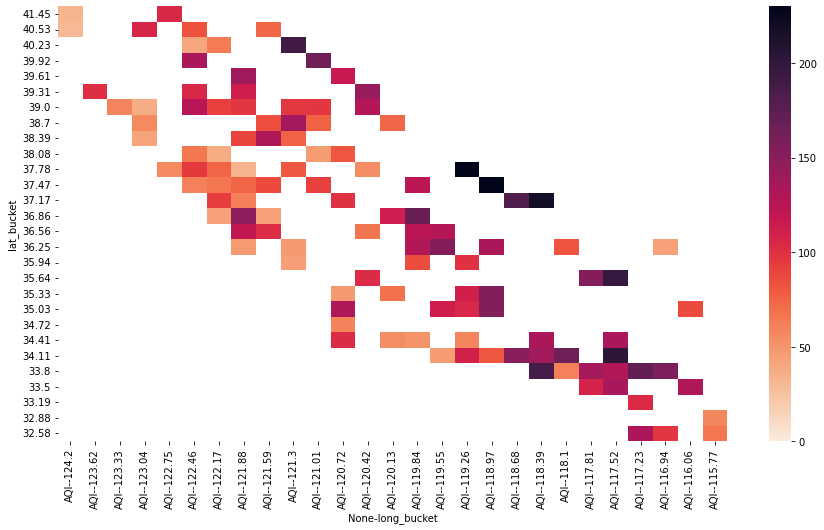

In [32]:
ca_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(ca_sep, np.median, 30)

#create visualization
plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

In [33]:
grader.check("q6b")

q6b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 6c: Analyze Heatmap

Look up where the dark regions correspond to. Does this heatmap make sense?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->

The dark regoins are primarily in the center, where longitude is around -119 and latitude is around 37. The heatmap makes sense. It has the same shape as the shape of California. It shows that the air is more polluted around the center and east side of California, which is more distant from the ocean, compared to other regions.

<!-- END QUESTION -->



<br/><br/>

---
## Part 3: Open-Ended EDA

Not that we have explored the data both spatially and temporally, we want to be able to look at what other indicators there are for air quality in California. Through the previous few questions we have discussed that wilfire data as well as temperature may be good indicators, but we can explitly look at correlations via the temperature to verify our hypothesis. Like temperature, there are other columns of data such as particulate matter, chemical concentrations, wind data, etc. Your open-ended EDA will be useful for filling in missing points in the heatmap that you created in question 4b. 

Your goal in this question is to find relationships between AQI and other features in the current datasets, across time and space. Your exploration can include, but is not limited to: 
- Looking at correlations between AQI and various columns of interest in `epa_data_CA`.
    - This will require some merging, which you can look at question 1 for reference. 
- Performing clustering and/or other unsupervised learning methods such as PCA to discover clusters or useful (combinations of) features in the data.
- Merging and exploring other external datasets that you may think are useful.

<!-- BEGIN QUESTION -->

### Question 7a - Code and Analysis

Please complete all of your analysis in the **single cell** below based on the prompt above.

<!--
BEGIN QUESTION
name: q7a
manual: True
points: 10
-->

In [34]:
epa_data.get('annual_county_aqi').head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7b - Visualization

Please create **two** visualizations to summarize your analysis above. The only restrictions are that these visualizations **cannot** simply be scatterplots between two features in the dataset(s) and **cannot** be of the same type (dont make two bar graphs, for example). 

<!--
BEGIN QUESTION
name: q7b
manual: True
points: 4
-->

In [35]:
epa_data.get('daily_temp').shape, epa_data.get('daily_wind').shape
temp_data = epa_data.get('daily_wind')
temp_data[temp_data['State Name'] == 'California'][['Units of Measure', 'Event Type', 'Observation Count', 'Observation Percent', 'Arithmetic Mean','1st Max Value', '1st Max Hour', 'AQI']]
# temp_data.columns

,Units of Measure,Event Type,Observation Count,Observation Percent,Arithmetic Mean,1st Max Value,1st Max Hour,AQI
8709,Degrees Fahrenheit,None,24,100.0,44.816667,58.8,13,NaN
8710,Degrees Fahrenheit,None,24,100.0,43.483333,59.5,15,NaN
8711,Degrees Fahrenheit,None,24,100.0,43.916667,61.5,14,NaN
8712,Degrees Fahrenheit,None,22,92.0,44.500000,59.0,11,NaN
8713,Degrees Fahrenheit,None,24,100.0,45.600000,54.9,15,NaN
...,...,...,...,...,...,...,...,...
63496,Degrees Fahrenheit,None,24,100.0,47.320833,54.7,14,NaN
63497,Degrees Fahrenheit,None,24,100.0,48.129167,54.7,15,NaN
63498,Degrees Fahrenheit,None,24,100.0,48.820833,61.5,15,NaN
63499,Degrees Fahrenheit,None,24,100.0,45.341667,55.6,14,NaN


In [37]:
cols = ['State Name', 'county Name', 'Year', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
aqs_sites = epa_data.get('aqs_sites')
daily_county_aqi = epa_data_CA.get('daily_county_aqi')

def table_selection(df):
    result = df
    result['Year'] = pd.DatetimeIndex(result['Date Local']).year
    result['Month'] = pd.DatetimeIndex(result['Date Local']).month
    result['Day'] = pd.DatetimeIndex(result['Date Local']).day
    # result = result[result['Year']== 2020]
    result['State ID'] = result['State Code'].astype(str).str.zfill(2)
    result['County ID'] = result['County Code'].astype(str).str.zfill(3)
    result['Site ID'] = result['Site Num'].astype(str).str.zfill(4)
    result['Defining Site'] = result['State ID'] + '-' + result['County ID'] + '-' + result['Site ID']
    result = result[['Arithmetic Mean', 'Defining Site', 'Year', 'Month', 'Day']]
    return result
    
temp_data = epa_data.get('daily_wind') 
temp_cleaned = table_selection(temp_data)
ca_temp_2020 = temp_cleaned.rename(columns = {'Arithmetic Mean' : 'Temp Mean'})

wind_data = epa_data.get('daily_temp')
wind_data = wind_data[wind_data['Units of Measure'] == 'Knots']
wind_cleaned = table_selection(wind_data)
ca_wind_2020 = wind_cleaned.rename(columns = {'Arithmetic Mean' : 'Wind Mean'})

co_data = epa_data.get('daily_co')
co_cleaned = table_selection(co_data)
ca_co_2020 = co_cleaned.rename(columns = {'Arithmetic Mean' : 'co Mean'})

no2_data = epa_data.get('daily_no2')
no2_cleaned = table_selection(no2_data)
ca_no2_2020 = no2_cleaned.rename(columns = {'Arithmetic Mean' : 'no2 Mean'})

so2_data = epa_data.get('daily_so2')
so2_cleaned = table_selection(so2_data)
ca_so2_2020 = so2_cleaned.rename(columns = {'Arithmetic Mean' : 'so2 Mean'})

ozone_data = epa_data.get('daily_ozone')
ozone_cleaned = table_selection(ozone_data)
ca_ozone_2020 = ozone_cleaned.rename(columns = {'Arithmetic Mean' : 'ozone Mean'})


aqs_sites['State ID'] = aqs_sites['State Code'].astype(str).str.zfill(2)
aqs_sites['County ID'] = aqs_sites['County Code'].astype(str).str.zfill(3)
aqs_sites['Site ID'] = aqs_sites['Site Number'].astype(str).str.zfill(4)
aqs_sites['Defining Site'] = aqs_sites['State ID'] + '-' + aqs_sites['County ID'] + '-' + aqs_sites['Site ID']
aqs_sites = aqs_sites[['Latitude', 'Longitude', 'Defining Site']] 
daily_county_aqi['Year'] = pd.DatetimeIndex(daily_county_aqi['Date']).year
new_df = daily_county_aqi.merge(aqs_sites,  how='left', left_on=['Defining Site'], right_on = ['Defining Site'])
epa_data_CA_merged1 = new_df[cols]

merge_col = ['Defining Site', 'Year', 'Month', 'Day']
epa_all = epa_data_CA_merged1.merge(ca_temp_2020, how = 'left', left_on=merge_col, right_on=merge_col)
epa_all = epa_all.merge(ca_wind_2020, how = 'left', left_on=merge_col, right_on=merge_col)
epa_all = epa_all.merge(ca_no2_2020, how = 'left', left_on=merge_col, right_on=merge_col)
epa_all = epa_all.rename(columns = {'county Name' : 'County Name'})
epa_all = epa_all.dropna()

epa_2020_CA_wind_temp = epa_all[(epa_all['Year'] == 2020) & (epa_all['State Name'] == 'California')].iloc[:, :-1]
epa_2020_CA_wind_temp.head()                                
                                
                                

,State Name,County Name,Year,Month,Day,AQI,Category,Defining Site,Latitude,Longitude,Temp Mean,Wind Mean
727,California,Butte,2020,1,3,74,Moderate,06-007-0008,39.76168,-121.84047,47.100000,1.329167
729,California,Butte,2020,1,5,60,Moderate,06-007-0008,39.76168,-121.84047,46.341667,1.158333
730,California,Butte,2020,1,6,47,Good,06-007-0008,39.76168,-121.84047,43.329167,1.612500
732,California,Butte,2020,1,8,68,Moderate,06-007-0008,39.76168,-121.84047,46.541667,1.929167
743,California,Butte,2020,1,19,66,Moderate,06-007-0008,39.76168,-121.84047,43.829167,0.829167


In [38]:
from sklearn import linear_model as lm
api_wind_model = lm.LinearRegression(fit_intercept=True)
api_temp_model = lm.LinearRegression(fit_intercept=True)

temp_mean = epa_2020_CA_wind_temp[['Temp Mean']]
wind_mean = epa_2020_CA_wind_temp[['Wind Mean']]
aqi = epa_2020_CA_wind_temp['AQI']
api_wind_model.fit(temp_mean, aqi)
api_temp_model.fit(wind_mean, aqi)

aqi_fitted_wind = api_wind_model.predict(temp_mean)
api_fitted_temp = api_temp_model.predict(wind_mean)

api_wind_model.intercept_, api_wind_model.coef_[0]

(-11.194309632941469, 1.2770397840707528)

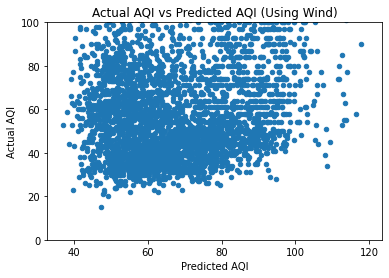

In [39]:
plt.scatter(aqi_fitted_wind, aqi, s=20)
plt.ylim(0, 100)
plt.title("Actual AQI vs Predicted AQI (Using Wind)")
plt.xlabel("Predicted AQI")
plt.ylabel("Actual AQI");

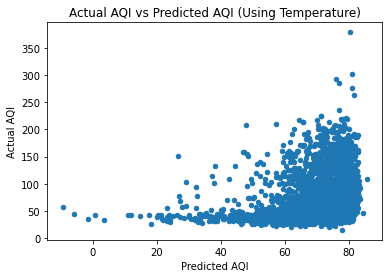

In [40]:
plt.scatter(api_fitted_temp, aqi, s=20)
plt.title("Actual AQI vs Predicted AQI (Using Temperature)")
plt.xlabel("Predicted AQI")
plt.ylabel("Actual AQI");

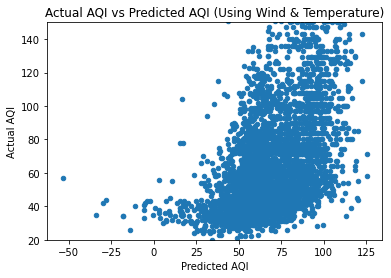

In [41]:
wind_temp = epa_2020_CA_wind_temp[['Wind Mean', 'Temp Mean']]
aqi_combined_model = lm.LinearRegression(fit_intercept=True)
aqi_combined_model.fit(wind_temp, aqi)
api_fitted_combined = aqi_combined_model.predict(wind_temp)
plt.scatter(api_fitted_combined, aqi, s=20)
plt.ylim(20, 150)
plt.title("Actual AQI vs Predicted AQI (Using Wind & Temperature)")
plt.xlabel("Predicted AQI")
plt.ylabel("Actual AQI");

In [42]:
month = epa_2020_CA_wind_temp[['Month']]
aqi_month_model = lm.LinearRegression(fit_intercept=True)
aqi_combined_model.fit(month, aqi)
aqi_fitted_month = aqi_combined_model.predict(month)

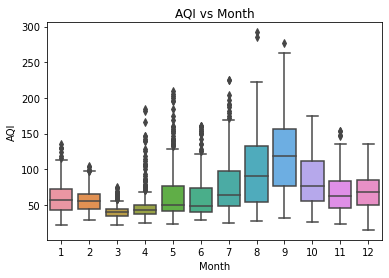

In [43]:
import seaborn as sns
temp = epa_2020_CA_wind_temp.copy()
temp = temp[(temp['AQI'] <=300) & (temp['AQI'] >= 15)]
sns.boxplot(x = 'Month', y='AQI', data = temp)
plt.title('AQI vs Month');

In [44]:
temp_groups = np.arange(15, 120, 3)
length = len(temp['AQI'])
result = [0] * length
for i in range(length):
    for val in temp_groups:
        if temp['Temp Mean'].iloc[i] >= val:
            result[i] = val
temp['temp_group'] = result
temp_group_count = temp.groupby('temp_group').agg(np.mean)

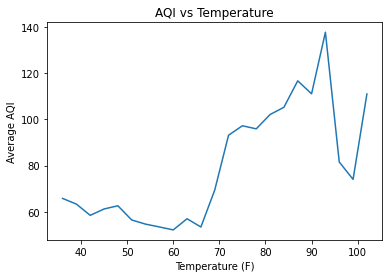

In [45]:
sns.lineplot(x = 'temp_group', y='AQI', data = temp_group_count, markers=False);
plt.title("AQI vs Temperature")
plt.ylabel("Average AQI")
plt.xlabel("Temperature (F)");

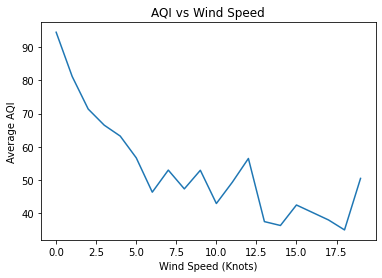

In [46]:
wind_groups = np.arange(0, 25, 1)
length = len(temp['AQI'])
result = [0] * length
for i in range(length):
    for val in wind_groups:
        if temp['Wind Mean'].iloc[i] >= val:
            result[i] = val
temp['wind_group'] = result
wind_group_count = temp.groupby('wind_group').agg(np.mean)

sns.lineplot(x = 'wind_group', y='AQI', data = wind_group_count, markers=False);
plt.title("AQI vs Wind Speed")
plt.ylabel("Average AQI")
plt.xlabel("Wind Speed (Knots)");

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 7c - Summary

In a paragraph, summarize the your findings and visualizations and explain how they will be useful for predicting AQI. Make sure that your answer is thoughtful and detailed in that it describes what you did and how you reached your conclusion. 

<!--
BEGIN QUESTION
name: q7c
manual: True
points: 4
-->

According to our box plot. The median AQI is generally low from March to June--about 35, though there are occasionally some outliers. For the rest of the year, the median AQI is relatively high, ranging from 50 to over 100. Then we attempt to visualize the relationship between wind and AQI. We used linear regression to model wind and AQI and found that there is a weak negative relationship between wind and AQI. The slope and intercept of our linear regression line is -0.00354 and 68.64432747071004. Next, we used both wind and temperature to model AQI. The coefficients are 1.27507759, -0.00799342, and the intercept is -9.754801085428369.  We discovered a positive correlation between temperature and AQI and a negative correlation between wind and AQI. Therefore, our model suggests that the higher the temperature is, the higher AQI is, and the lower the strength of wind, the higher AQI is (the air is more polluted), which is helpful when predicting AQI. After modeling the data with linear regression, we also used line plots to visualize the correlation found utilizing linear regression. The first line plot visualizes relationship between temperature and AQI. The x-axis is temperature, which ranges from 15 Fahrenheit to 120 Fahrenheit and increases by 3 Fahrenheit each time; the y-axis is the mean AQI of every specific temperature. Although the mean AQI fluctuates as temperature increases, we can see that the mean AQI increases as temperature increases. The second line plot visualizes relationship between wind and AQI. The x-axis is the strength of wind, which ranges from 0 to 25 Knots; the y-axis is the mean AQI of every specific wind strength.

<!-- END QUESTION -->



<br/><br/>

---
## Part 4: Guided Modeling

For this part, we will be looking at some open-ended modeling approaches to answering the question of predicting AQI given a location and a date. 

### Question 8 - Interpolation

For this part, we will be using a simple interpolation to find the missing grid values for AQI on the heatmap visualization that you produced in part 1. Simple linear interpolation just takes the locations' values and averages them to produce an estimate of the current location. Though this is not as predictive (we are not predicting based on features about the location itself), it will give you a sense of the task at hand for the remainder of the project. 

As a reminder, the heatmap produced after running the cell below is the one you produced for question 6b when creating a visualization for the AQI in California for the month of september. It produces white spaces where there exist `NaN` values in the pivot table. 

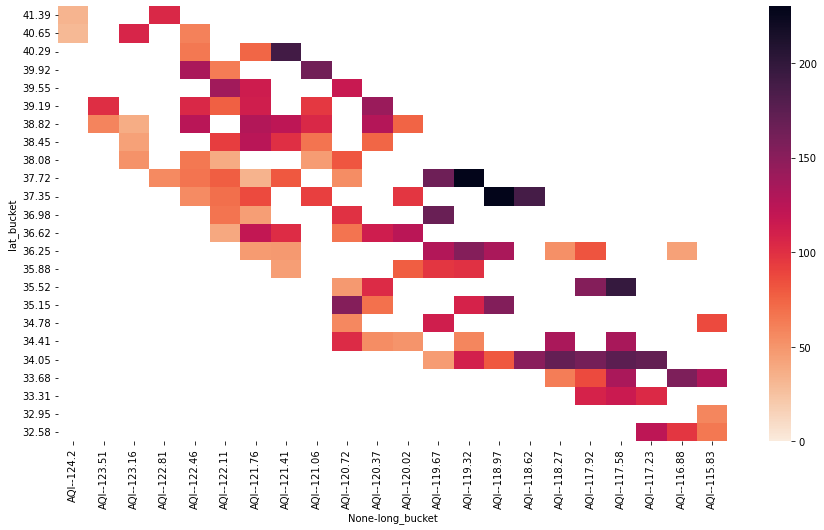

In [47]:
table_sep = epa_data_CA_merged[epa_data_CA_merged['Month'] == 9]
heatmap_data = bucket_data(table_sep, np.median, 25)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()

<br/>

### Question 8a - Simple Linear Interpolation
As previously mentioned, interpolation is a technique that is used to predict labels in a dataset by forming a model out of the data that is already labelled. In this case, we have a pivot table that we use to create a heatmap, but there contains many `NaN` values that we want to fill in. 

- Create the function `fill_bucket` that takes in the following parameters:
    - `pivot_table`: the pivot table that we are providing. 
    - `lat_bucket`: the bucket number that the latitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $, from lowest to highest value latitudes. 
    - `lon_bucket`: the bucket number that the longitude is in, indexed by zero. ex. if there are 25 buckets, they are numbered $ 0, 2, \dots 24 $. from lowest to highest value longitudes.
    
- In the pivot table, every value has cells above (A cells), cells below (B cells), cells to the left (L cells), and cells to the right (R cells). We will say that a direction (R for example) is valid if and only if there exists a cell **anywhere** to its right that is not `NaN`. The closest such cell will be called the "closest R cell". The same goes for the rest of the directions. For the cases below, assuming that our current cell is called cell K. 
    - If cell K is not `NaN`, then simply return the AQI at that given cell.
    - **Only** if there are **at least** three valid directional cells (ex. has A, B, and L valid but not R valid), we will call K *interpolable*. If K is *interpolable*, then interpolate K by assigning it an AQI value equal to the average of the closest cell AQIs in each of the valid directions. 
    - If K is *not interpolable*, then do not do anything and simply return `NaN`.
- The return value of `fill_bucket` should be the the value assigned to K. **DO NOT** mutate the cell K in the pivot table yet.

<!--
BEGIN QUESTION
name: q8a
points: 6
-->

In [48]:
def fill_bucket(pivot_table, lat_bucket, lon_bucket):
    val = pivot_table.iloc[lat_bucket, lon_bucket]
    if ~ np.isnan(val):
        return val
    vals = []
    columns = pivot_table.shape[1]
    rows = pivot_table.shape[0]
    # Left
    for L_lon in range (lon_bucket - 1, -1, -1):
        L = pivot_table.iloc[lat_bucket, L_lon]
        if ~np.isnan(L):
            vals.append(L)
            break
    
    # Right
    for R_lon in range (lon_bucket + 1, columns):
        R = pivot_table.iloc[lat_bucket, R_lon]
        if ~np.isnan(R):
            vals.append(R)
            break
            
    # Above
    for A_lat in range(lat_bucket - 1, -1, -1):
        A = pivot_table.iloc[A_lat, lon_bucket]
        if ~np.isnan(A):
            vals.append(A)
            break
            
    # Below
    for B_lat in range (lat_bucket + 1, rows):
        B = pivot_table.iloc[B_lat, lon_bucket]
        if ~np.isnan(B):
            vals.append(B)
            break
    
    if len(vals) >= 3:
        return np.mean(vals)
    
    return np.nan
    
fill_bucket(heatmap_data, 1, 19)

94.83333333333333

In [49]:
grader.check("q8a")

q8a results: All test cases passed!

<br/>

### Question 8b - Create Filled Heatmap

Now that you have created the `fill_bucket` function, we want to actually use it to fill in the values in `heatmap_data`. Complete the function `fill_all` that takes in the pivot table and fills in all the values and produces a pivot table with the updated values. **DO NOT** mutate the original pivot table. Instead, produce a new pivot table that that contains the filled values. 

One point to note is that when we update a cell here, we do not use any surrounding *interpolated* cells to do our interpolation on any given cell. As a result, we will always use the **original** pivot table to find surrounding cells and interpolate.

<!--
BEGIN QUESTION
name: q8b
points: 3
-->

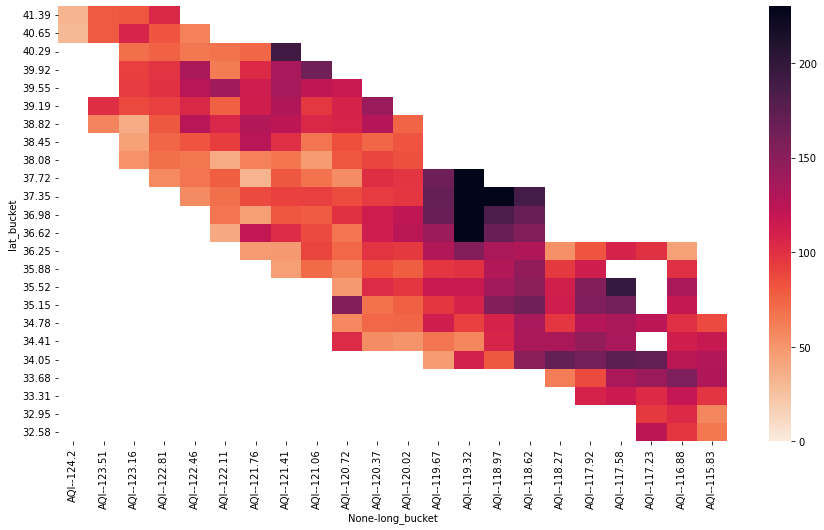

In [51]:
def fill_all(pivot_table):
    result = pivot_table.copy()
    columns = pivot_table.shape[1]
    rows = pivot_table.shape[0]
    for r in range(rows):
        for c in range(columns):
            result.iloc[r, c] = fill_bucket(pivot_table, r, c)
    return result

filled_heatmap_data = fill_all(heatmap_data)

plt.figure(figsize=(15, 8))
ax = sns.heatmap(filled_heatmap_data, vmin=0, vmax=230, cmap = sns.cm.rocket_r)
ax.invert_yaxis()
plt.show()   


In [52]:
grader.check("q8b")

q8b results: All test cases passed!

<!-- BEGIN QUESTION -->

<br/>

### Question 8c - Other Interpolation Ideas

Instead of just interpolating in a simple fashion as we did above, suggest one other way to interpolate (that actually works so do not just say "put the average of all cells in every `NaN` cell). For example, you can take into account of the distance of the surrounding cells, the number of cells you use, and more. 

<!--
BEGIN QUESTION
name: q8c
points: 2
manual: True
-->

Instead of using 4 directions R, L, A, B, we can calculate the 4 nearest neighbors that are not NaN, and attach weight relative to their distance. The more distant, the less weight. Then we calculate the avergae of the 4.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br/>

### Question 9 - Choosing your Loss Function

Let us say that you are trying to define a loss function $L(x_{i}, y_{i})$ to use for model, where $x_{i}$ is the input and the $y_{i}$ is a qualitative variable that that model outputs, consisting of the following five groups: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. How would you design your loss function to evaluate your model?

<!--
BEGIN QUESTION
name: q9
manual: True
points: 2
-->

Since we plan to use a decision tree, we will use a entropy loss function.

<!-- END QUESTION -->



</br></br>

### Question 10: Creating your own Model!

Now that you have an idea of how to interpolate values, we will be using something more predictive. In this part, your final goal is to be creating a model and function that uses **at least four** features, with at least one of those four features being from an external dataset that you bring in and process yourself. Here are some rules on the model that you should follow: 

- Using your open-ended EDA analysis, use at least three features in the dataset provided to come up with some sort of predictive model for the AQI for remaining locations not predicted in the heatmap. You are **NOT** allowed to use any more than **one** of the particulate matter features for this model i.e. ozone or CO2 concentrations for example. 
    - The reason behind this is that AQI is directly based on these values, so there will be in some sense a near 100\% correlation between AQI and these features under some transformations. 
- Use at least one feature that comes from an external dataset of choice. Some examples are geographical region (categorical), elevation (quantitative), or wilfire data. 
    - Reference question 2c of this project to see how to merge external data with the current EPA data.
- Your model should, at the end, predict one of the following broad categories for the AQI: good, moderate, unhealthy for sensitive groups, unhealthy, very unhealthy, or hazardous. Note that this specification is different from `fill_bucket` in the sense that instead of returning a value, you will be returning a string for a category.
    - As a result, you can either directly predict the category, or the AQI (ex. through regression) and then convert to the category. Category ranges for AQI can be found online.
- The final model should be validated with some data that you hold out. You decide how to do this but there should be some model validation accuracy reported. You should be using the loss function that you designed in question 3 in order to do this.

---

#### Deliverables
<br/>

**`features`**: This should be a `pd.DataFrame` object that represents the design matrix that will be fed in as input to your model. Each row represents a data point and each column represents a feature. Essentially your $X$ matrix. 

**`targets`**: This should be a numpy array that where each value corresponds to the AQI value or AQI category for each of the data points in `features`. Essentially your $y$ vector. 

**`build_model`**: This function should have two parameters: `features` that will be used as input into your model as a `pd.DataFrame` object, and `targets` should be a numpy array of AQI values OR AQI categories. It should return a *function* or *object* that represents your model.

**`predict`**: This function should have two parameters: `model`, the model that you build from the previous function `build_model`, and `features` that represent the design matrix for the test values that we want to predict. It should return the **AQI category** (not a value) that the model predicts for these inputs.

<!-- BEGIN QUESTION -->

<br/>

### Question 10a: Choose Features and Model

First, decide on the features that you will be using for your model. How predictive do you think each of the features that you chose will be of the AQI category? Then, how will you choose to make your model (multiple regression, decision trees, etc.)?

<!--
BEGIN QUESTION
name: q10a
points: 2
manual: True
-->

The features that we will be using are 'Temp Mean', 'Wind Mean', 'so2 Mean', 'AADT', so we incorporated the data on traffic into this. We think that each of these will be pretty predictive as they are in some sense directly related to the AQI levels. Since our target AQI is categorical data, we decided to use a decision tree for our model. 

<!-- END QUESTION -->

<br/>

### Question 10b: Build Features

Create the `build_features` function as described at the beginning of this part. You should also do any cleaning or merging of internal or external datasets in this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10b
points: 3
-->

In [53]:
epa_withtra = epa_all.merge(gpd_epa_traffic.loc[:, ['Defining Site', 'Month', 'Day', 'AADT']], how = 'left', left_on = ['Defining Site', 'Month', 'Day'],right_on = ['Defining Site', 'Month', 'Day'])
epa_withtra = epa_withtra.merge(ca_so2_2020, how = 'left', left_on=['Defining Site', 'Month', 'Day'], right_on=['Defining Site', 'Month', 'Day'])
epa_withtra = epa_withtra.dropna()

num_rows = epa_withtra.shape[0]
aqis = epa_withtra['AQI']
classification = []
for i in range(num_rows):
    aqi = aqis.iloc[i]
    if aqi <= 50:
        classification.append('good')
    elif aqi <= 100:
        classification.append('moderate')
    elif aqi <= 150:
        classification.append('unhealthy sensitive groups')
    elif aqi <= 200:
        classification.append('unhealthy')
    elif aqi <= 300:
        classification.append('very unhealthy')
    else:
        classification.append('hazardous')
        
epa_withtra['classification'] = classification
features = epa_withtra[['Temp Mean', 'Wind Mean', 'so2 Mean', 'AADT']]
targets = epa_withtra['classification']

features.head()


,Temp Mean,Wind Mean,so2 Mean,AADT
78,47.433333,0.912500,0.066667,307000
79,47.433333,0.912500,0.037500,307000
80,51.441667,1.000000,0.141667,307000
81,51.441667,1.000000,0.112500,307000
82,47.204167,2.904167,0.000000,307000


In [54]:
grader.check("q10b")

q10b results: All test cases passed!

<br/>

### Question 10c: Build Your Model!

Create the `build_model` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10c
points: 8
-->

In [55]:
from sklearn import tree

def build_model(features, targets):
    decision_tree_model = tree.DecisionTreeClassifier()
    decision_tree_model = decision_tree_model.fit(features, targets)
    return decision_tree_model

In [56]:
grader.check("q10c")

q10c results: All test cases passed!

<br/>

### Question 10d: Predict Points

Create the `predict` function as described at the beginning of this part. Make sure to read the specifications of the function very carefully. The autograder will provide some sanity checks on your output.

<!--
BEGIN QUESTION
name: q10d
points: 4
-->

In [57]:
categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]
def predict(model, features):
    AQI_pred = model.predict(features)
    return AQI_pred

In [58]:
grader.check("q10d")

q10d results: All test cases passed!

<br/>

### Question 10e: Model Validation and Performance

Now that you have finished making your model, we want to see how well it performs on our data. In this question, use the following cell to split your data into training and validation sets. You should partition 70\% of your data to be used as your training set, and the remaining to be used as your validation set. 

Assign `binary_error` to be the **fraction of inputs on your validation set that the your `predict` function classifies incorrectly.** Note that this is a binary loss in some sense as it assigns a loss of 1 to those points predicted incorrectly, and a loss of 0 to those points predicted correctly.

Assign `cv_error` to be the the error on the validation set produced by the loss function $ L $ that you designed in question 3.

*Hint*: you can use `train_test_split` from `sklearn`.

<!--
BEGIN QUESTION
name: q10e
points: 8
-->

In [60]:
def entropy(x):
    normalized_x = x / np.sum(x)
    return sum(-normalized_x * np.log2(normalized_x))

from sklearn.model_selection import train_test_split

features_train, features_test, y_train, y_test = train_test_split(features, targets, test_size=0.30)
y_fitted = predict(build_model(features_train, y_train), features_test)
wrong_pred = sum(y_fitted != y_test)

binary_error = wrong_pred / len(y_test)

cat_count = []
unique_cat =  list(set(y_fitted))
for i in range(len(unique_cat)):
    cat_count.append((y_fitted == unique_cat[i]).sum())
                     
cv_error = entropy(cat_count)
binary_error, cv_error

(0.11635220125786164, 1.4678308450939543)

In [61]:
grader.check("q10e")

q10e results: All test cases passed!

<br/><br/>

---
## Part 5: Open-Ended Modeling

Now that you have had some experience with creating the a model from scratch using the existing data, you are now ready to explore other questions, such as the ones in your design document. In this section, you will use the tools that we developed in the previous parts to answer the hypothesis of your choice! Note that breaking your model-building and analysis process into modularized functions as you did above will make your code more interpretable and less error-prone. 

<!-- BEGIN QUESTION -->

### Question 11a

Train a baseline model of your choice using any supervised learning approach we have studied to answer your hypothesis and predict something related to AQI; you are not limited to a linear model. However, you may use a maximum of **three features** for this part. After training, evaluate it on some validation data that you hold out yourself. 

<!--
BEGIN QUESTION
name: q11a
points: 5
manual: True
-->

In [62]:
pop_density = pd.read_csv("data/population_density.csv")
pop_density.rename(columns={'CTYNAME':'County', 'pop2021':'population', 'popDensity':'density'}, inplace=True)
pop_density['County'] = pop_density['County'].str.split(' County', expand=True)[0]
pop_density = pop_density.loc[:, {'County', 'density'}]
epa_withpop = epa_all.merge(pop_density, how = 'left', left_on = 'County Name', right_on = 'County')
epa_withpop = epa_withpop.drop('County', 1).rename(columns = {'population': 'Population'})
epa_withpop = epa_withpop.merge(ca_so2_2020, how = 'left', left_on=['Year', 'Defining Site', 'Month', 'Day'], right_on=['Year', 'Defining Site', 'Month', 'Day'])
epa_withpop = epa_withpop.dropna()
epa_withpop.head()

,State Name,County Name,Year,Month,Day,AQI,Category,Defining Site,Latitude,Longitude,Temp Mean,Wind Mean,no2 Mean,density,so2 Mean
78,California,Fresno,2020,1,2,102,Unhealthy for Sensitive Groups,06-019-0011,36.78538,-119.77321,47.433333,0.912500,13.830435,1371.1408,0.066667
79,California,Fresno,2020,1,2,102,Unhealthy for Sensitive Groups,06-019-0011,36.78538,-119.77321,47.433333,0.912500,13.830435,1371.1408,0.037500
80,California,Fresno,2020,1,3,88,Moderate,06-019-0011,36.78538,-119.77321,51.441667,1.000000,16.465217,1371.1408,0.141667
81,California,Fresno,2020,1,3,88,Moderate,06-019-0011,36.78538,-119.77321,51.441667,1.000000,16.465217,1371.1408,0.112500
82,California,Fresno,2020,1,5,55,Moderate,06-019-0011,36.78538,-119.77321,47.204167,2.904167,4.386957,1371.1408,0.000000


In [63]:


from sklearn import linear_model as lm
def build_model_linear(features, targets):
    reg = lm.LinearRegression(fit_intercept=True).fit(features, targets)
    return reg


categories_11a = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]
bins = [-np.inf] + list(epa_withpop.groupby('Category').agg(max).sort_values('AQI', ascending = True).loc[:, 'AQI'])
def predict_linear(model, features):
    AQI_pred = model.predict(features)
    return AQI_pred

def classify(aqis):
    classification = []
    for aqi in aqis:
        if aqi <= 50:
            classification.append('good')
        elif aqi <= 100:
            classification.append('moderate')
        elif aqi <= 150:
            classification.append('unhealthy sensitive groups')
        elif aqi <= 200:
            classification.append('unhealthy')
        elif aqi <= 300:
            classification.append('very unhealthy')
        else:
            classification.append('hazardous')
    return classification

categories_11a1 = epa_withpop['Category']
new_cat = []
for i in range(len(categories_11a1)):
    if categories_11a1.iloc[i] == 'Good':
        new_cat.append('good')
    elif categories_11a1.iloc[i] == 'Moderate':
        new_cat.append('moderate')
    elif categories_11a1.iloc[i] == 'Unhealthy for Sensitive Groups':
        new_cat.append('unhealthy sensitive groups')
    elif categories_11a1.iloc[i] == 'Unhealthy':
        new_cat.append('unhealthy')
    elif categories_11a1.iloc[i] == 'Very Unhealthy':
        new_cat.append('very unhealthy')
    else:
        new_cat.append('hazardous')

epa_withpop['classification'] = new_cat
features_11a = epa_withpop[['Wind Mean', 'so2 Mean', 'density']]
targets_11a = epa_withpop['AQI']
features_11a.head()
targets_11a.head()

78    102
79    102
80     88
81     88
82     55
Name: AQI, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split
features_train, features_test, y_train, y_test = train_test_split(features_11a, targets_11a, test_size=0.30, random_state=42)
model = build_model_linear(features_train, y_train)

y_fitted = predict_linear(model, features_test)

y_fitted_cat = classify(y_fitted)
y_test_cat = classify(y_test)
correct_pred = sum([y_fitted_cat[i] == y_test_cat[i] for i in range(len(y_test_cat))])

binary_error = (len(y_test) - correct_pred) / len(y_test)

def mse(y_predit, y):
    return sum((y_predit - y) ** 2) / len(y_fitted)

cv_error = mse(y_fitted, y_test) 
binary_error, cv_error

(0.3801916932907348, 637.8551261810167)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11b

Explain and summarize the model that you used. In your summary, make sure to include the model description, the inputs, the outputs, as well as the cross-validation error. Additionally, talk a little bit about what you would change to your baseline model to improve it. The expected length of your summary should be 8-12 sentences. 

<!--
BEGIN QUESTION
name: q11b
points: 2
manual: True
-->

We used linear regression model, 3 features (averag wind speed, average so2 level, and population density) as inputs, and the predicted category as output. The binary error is 0.38, which is relatively high. Since category is not a quantitative variable, we used predicted AQI and actual AQI level to compute the mean square error. The mse is 637, which is also pretty high. There are lots of rooms for improvements. We can add more features like traffic level in Q10. Also, since the result we predict is quanlitative, linear regression may not be the best tool. Therefore we plan to change our model to decision tree, which we expect to produce a better result than linear regression.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11c

Improve your model from part 11a based on the improvements that you suggested in part 11b. This could be the addition of more features, performing additional transformations on your features, increasing/decreasing the complexity of the model itself, or really anything else. You have no limitation on the number of features you can use, but you are required to use at least **one external dataset** that you process and merge in yourself. 

<!--
BEGIN QUESTION
name: q11c
points: 8
manual: True
-->

In [66]:
epa_withpop_tra = epa_withpop.merge(gpd_epa_traffic.loc[:, ['Defining Site', 'Month', 'Day', 'AADT']], how = 'left', left_on = ['Defining Site', 'Month', 'Day'],right_on = ['Defining Site', 'Month', 'Day'])

feature_original = epa_withpop_tra[['Temp Mean', 'Wind Mean', 'so2 Mean']]
feature_withpop = features_only_density = epa_withpop_tra[['Temp Mean', 'Wind Mean', 'so2 Mean', 'density']]

features_only_density = epa_withpop_tra[['density']]
features_only_so2 = epa_withpop_tra[['so2 Mean']]
features_only_temp = epa_withpop_tra[['Temp Mean']]
features_only_wind = epa_withpop_tra[['Wind Mean']]
features_only_AADT = epa_withpop_tra[['AADT']]

targets_impmodel = epa_withpop_tra['Category']

from sklearn import tree

def dicision_tree(features, targets):
    decision_tree_model = tree.DecisionTreeClassifier()
    decision_tree_model = decision_tree_model.fit(features, targets)
    return decision_tree_model

categories = ["good", "moderate", "unhealthy sensitive groups", "unhealthy", "very unhealthy", "hazardous"]
def decision_tree_predict(model, features):
    AQI_pred = model.predict(features)
    return AQI_pred


In [67]:
from sklearn.model_selection import train_test_split
features_train, features_test, y_train, y_test = train_test_split(feature_withpop, targets_impmodel, test_size=0.30)
y_fitted = predict(build_model(features_train, y_train), features_test)

wrong_pred = sum(y_fitted != y_test)

binary_error = wrong_pred / len(y_test)


cat_count = []
unique_cat =  list(set(y_fitted))
for i in range(len(unique_cat)):
    cat_count.append((y_fitted == unique_cat[i]).sum())
                     
cv_error = entropy(cat_count)
binary_error, cv_error

(0.09748427672955975, 1.523118617844454)

In [68]:

def entropy(x):
    normalized_x = x / np.sum(x)
    return np.sum(-normalized_x * np.log2(normalized_x))

from sklearn.model_selection import train_test_split

#without population
binary_error_original_all = []
binary_error_withpop_all = []
for _ in range(1000):
    features_train_original, features_test_original, y_train_original, y_test_original = train_test_split(feature_original, targets_impmodel, test_size=0.30)
    features_train_withpop, features_test_withpop, y_train_withpop, y_test_withpop = train_test_split(feature_withpop, targets_impmodel, test_size=0.30)
    y_fitted_original = decision_tree_predict(dicision_tree(features_train_original, y_train_original), features_test_original)
    y_fitted_withpop = decision_tree_predict(dicision_tree(features_train_withpop, y_train_withpop), features_test_withpop)
    wrong_pred_original = sum(y_fitted_original != y_test_original)
    wrong_pred_withpop = sum(y_fitted_withpop != y_test_withpop)
    binary_error_original = wrong_pred_original / len(y_test_original)
    binary_error_withpop = wrong_pred_withpop / len(y_test_withpop)

    binary_error_original_all.append(binary_error_original)
    binary_error_withpop_all.append(binary_error_withpop)


from scipy.stats import ttest_ind
ttest_ind(binary_error_withpop_all, binary_error_original_all, equal_var = False)

Ttest_indResult(statistic=-13.432581006314921, pvalue=1.9178703208639383e-39)

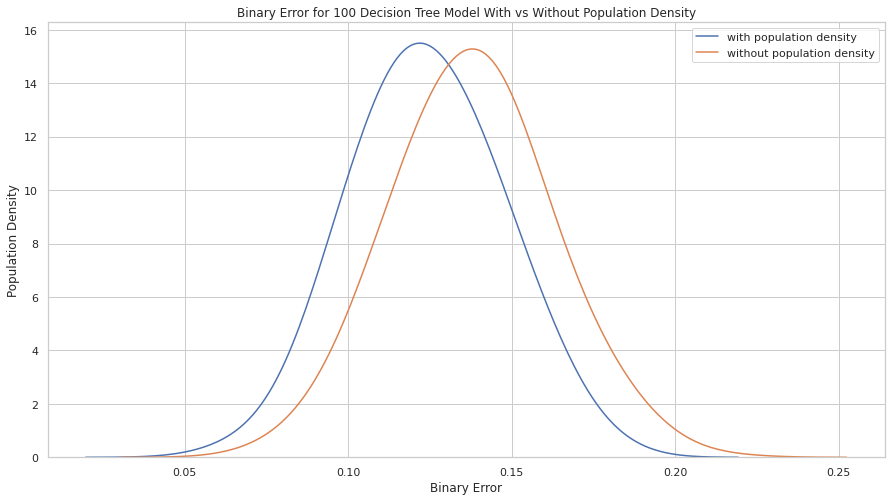

In [69]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style('whitegrid')
sns.kdeplot(binary_error_withpop_all, bw=0.5, label='with population density')
sns.kdeplot(binary_error_original_all, bw=0.5, label ='without population density')
plt.legend()
plt.title('Binary Error for 100 Decision Tree Model With vs Without Population Density')
plt.xlabel('Binary Error')
plt.ylabel('Population Density');

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 11d

Compare and contrast your baseline model and (hopefully) improved model. Make sure to compare their validation errors. Were you able to successfully answer your research question and evaluate your hypothesis? Summarize in a few sentences the conclusions that you can draw from your model and predictions. The expected length of your response should be 8-10 sentences. 

<!--
BEGIN QUESTION
name: q11d
points: 3
manual: True
-->

After including mroe variables and changing our model from linear regression to decision tree, the prediction is noticeably more accurate. The binary error decreases from around 0.4 to around 0.15, a significant improvement. Also, we conducted a t-test to answer our hypothesis that population density is correlated with AQI level. We calculated the binary error for 2 models, 1 with population density and 1 without, each 100 times and got the average value. As a result, the t-value is -5, and the correponding p-value is 10 ^-8, which is significantly less than 0.05. Thus, we accept out hypothesis that population density is correlated with AQI level.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [70]:
grader.check_all()

q10b results: All test cases passed!

q10c results: All test cases passed!

q10d results: All test cases passed!

q10e results: All test cases passed!

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q3a results: All test cases passed!

q4a results: All test cases passed!

q4i results: All test cases passed!

q5a results: All test cases passed!

q6a results: All test cases passed!

q6b results: All test cases passed!

q8a results: All test cases passed!

q8b results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [66]:
# Save your notebook first, then run this cell to export your submission.
grader.export()